In [1]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis - Without Autoencoder on Unscaled Targets

In [2]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

## Load Data

In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

## Create a Neural Network for Regression

In [4]:
import random


class NNRegressor(L.LightningModule):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU, optimizer=torch.optim.Adam, lr=1e-3, weight_decay=1e-4):
        super(NNRegressor, self).__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.weight_decay = weight_decay
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

        self.loss_metric = MeanSquaredError()
        self.val_metric = MeanSquaredError()
        self.test_metric = MeanSquaredError()



    def forward(self, x):
        y = self.network(x)
        return y
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mse", self.loss_metric(y_hat, y), prog_bar=True)

        return loss
    
    def on_training_epoch_end(self):
        self.log("train_mse", self.loss_metric.compute())
        self.loss_metric.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_mse", self.val_metric(y_hat, y), prog_bar=True)

    def on_validation_epoch_end(self):
        self.log("val_mse", self.val_metric.compute())
        self.val_metric.reset()
        
    def configure_optimizers(self):
        return self.optimizer(self.network.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mse", self.test_metric(y_hat, y), prog_bar=True)
        return loss
    
    def on_test_epoch_end(self):
        self.log("test_mse", self.test_metric.compute())
        self.test_metric.reset()

simple_nn = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8
)

## Create NNRegressor and Summarize


In [5]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8
), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
NNRegressor                              [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 1978]                 1,958,220
│    └─BatchNorm1d: 2-2                  [1, 1978]                 3,956
│    └─LeakyReLU: 2-3                    [1, 1978]                 --
│    └─Dropout: 2-4                      [1, 1978]                 --
│    └─Linear: 2-5                       [1, 3956]                 7,828,924
│    └─BatchNorm1d: 2-6                  [1, 3956]                 7,912
│    └─LeakyReLU: 2-7                    [1, 3956]                 --
│    └─Dropout: 2-8                      [1, 3956]                 --
│    └─Linear: 2-9                       [1, 7912]                 31,307,784
│    └─BatchNorm1d: 2-10                 [1, 7912]                 15,824
│    └─LeakyReLU: 2-11                   [1, 7912]   

## Create and Train Neural Network Regressor

### Create and train initial model for code testing

In [6]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=2
)
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.9 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.689   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [7]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     716.8444213867188     │
│         test_mse          │     716.8444213867188     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 716.8444213867188, 'test_mse': 716.8444213867188}]

### Plot results from initial model

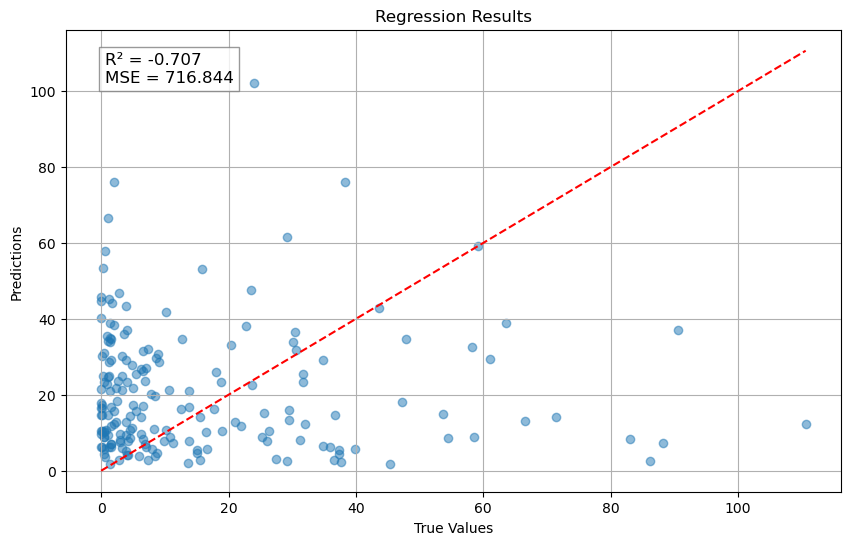

In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def plot_regression_results(model, dataloader, title="Regression Results"):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = model(x)
            y_true.append(y)
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.grid(True)
    # Add R² and MSE text in upper left corner
    plt.text(
        0.05, 0.95,
        f'R² = {r2:.3f}\nMSE = {mse:.3f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
    )
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

### Perform Hyperparameter Tuning with Optuna

In [9]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model =NNRegressor(
        input_dim=len(cancer_dm.ds_train[0][0]),
        n_layers=n_layers,
        dropout=dropout,
        activation=activation,
        optimizer=optimizer,
        lr=learning_rate,
        weight_decay=weight_decay,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"nn_trial_{trial.number}", max_epochs=50, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [10]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="deep_regressor_study")
study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-18 14:53:47,138] A new study created in memory with name: deep_regressor_study


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:53:54,916] Trial 0 finished with value: 1037.0838623046875 and parameters: {'n_layers': 3, 'dropout': 7.989955857756748e-05, 'learning_rate': 1.1933132827310471e-05, 'weight_decay': 0.002452951953070187, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 0 with value: 1037.0838623046875.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:54:04,255] Trial 1 finished with value: 1034.0025634765625 and parameters: {'n_layers': 4, 'dropout': 0.27150081973813806, 'learning_rate': 1.7637872255337133e-05, 'weight_decay': 0.00012073355776527528, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 1 with value: 1034.0025634765625.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:54:50,587] Trial 2 finished with value: 928.3951416015624 and parameters: {'n_layers': 5, 'dropout': 0.32057057792045973, 'learning_rate': 1.5459194402268157e-05, 'weight_decay': 0.0059117485393837795, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 2 with value: 928.3951416015624.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:55:19,251] Trial 3 finished with value: 1029.854736328125 and parameters: {'n_layers': 3, 'dropout': 0.2583984693492947, 'learning_rate': 2.0746965068805642e-05, 'weight_decay': 0.009780579037956956, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 2 with value: 928.3951416015624.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:55:27,722] Trial 4 finished with value: 1050.9501953125 and parameters: {'n_layers': 3, 'dropout': 0.13344669502609346, 'learning_rate': 0.0028773781924831122, 'weight_decay': 1.3823758348019807e-05, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 2 with value: 928.3951416015624.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:55:44,006] Trial 5 finished with value: 890.6316528320312 and parameters: {'n_layers': 4, 'dropout': 0.2918710132877048, 'learning_rate': 0.000410955001301548, 'weight_decay': 0.0008335994726421812, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 5 with value: 890.6316528320312.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:55:58,253] Trial 6 finished with value: 1003.818115234375 and parameters: {'n_layers': 4, 'dropout': 0.3924808773744186, 'learning_rate': 0.002872577861717131, 'weight_decay': 0.0009660831575130967, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 5 with value: 890.6316528320312.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:56:07,978] Trial 7 finished with value: 1243.043701171875 and parameters: {'n_layers': 3, 'dropout': 0.36522165393832684, 'learning_rate': 0.0036042643237905883, 'weight_decay': 0.00036144815854935615, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 5 with value: 890.6316528320312.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:56:18,289] Trial 8 finished with value: 1186.718017578125 and parameters: {'n_layers': 4, 'dropout': 0.09296393479793907, 'learning_rate': 0.0015170646636090978, 'weight_decay': 0.00014555240675002043, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 5 with value: 890.6316528320312.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:56:29,687] Trial 9 finished with value: 1231.9871826171875 and parameters: {'n_layers': 4, 'dropout': 0.14126586234979654, 'learning_rate': 0.0018065155438344376, 'weight_decay': 9.67975531261502e-05, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 5 with value: 890.6316528320312.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:56:43,998] Trial 10 finished with value: 1523.403564453125 and parameters: {'n_layers': 5, 'dropout': 0.4998499549223694, 'learning_rate': 0.00018878760258219795, 'weight_decay': 2.228105165677163e-05, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 5 with value: 890.6316528320312.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:56:59,054] Trial 11 finished with value: 1149.13427734375 and parameters: {'n_layers': 5, 'dropout': 0.34795211825392885, 'learning_rate': 0.00014448284919197808, 'weight_decay': 0.007437879275763646, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 5 with value: 890.6316528320312.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:57:17,343] Trial 12 finished with value: 1279.2686767578125 and parameters: {'n_layers': 5, 'dropout': 0.22005206716676512, 'learning_rate': 6.558720876035802e-05, 'weight_decay': 0.002151644046271936, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 5 with value: 890.6316528320312.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 20.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.319    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:57:29,482] Trial 13 finished with value: 3353.265869140625 and parameters: {'n_layers': 5, 'dropout': 0.4505006883395642, 'learning_rate': 0.000551571787745128, 'weight_decay': 0.0009337152072156824, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 5 with value: 890.6316528320312.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:57:53,256] Trial 14 finished with value: 858.828369140625 and parameters: {'n_layers': 4, 'dropout': 0.30842715566321594, 'learning_rate': 0.00059935089327359, 'weight_decay': 0.0036808988501540528, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 14 with value: 858.828369140625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:58:08,636] Trial 15 finished with value: 962.1817626953124 and parameters: {'n_layers': 4, 'dropout': 0.19423453239988955, 'learning_rate': 0.0006019451517110413, 'weight_decay': 0.0005814189020726035, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 14 with value: 858.828369140625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 14:58:25,558] Trial 16 finished with value: 977.1424560546876 and parameters: {'n_layers': 4, 'dropout': 0.3020425540336406, 'learning_rate': 0.007950486335579944, 'weight_decay': 0.002503330398986173, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 14 with value: 858.828369140625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-18 14:58:59,333] Trial 17 finished with value: 733.0496215820312 and parameters: {'n_layers': 4, 'dropout': 0.4150142339062526, 'learning_rate': 0.000493898367710332, 'weight_decay': 0.0014165252681537796, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 17 with value: 733.0496215820312.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 4.4 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.648    Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 15:00:42,036] Trial 18 finished with value: 1018.3089599609376 and parameters: {'n_layers': 3, 'dropout': 0.41072807905031683, 'learning_rate': 6.401182838113382e-05, 'weight_decay': 0.0039599944157165294, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 17 with value: 733.0496215820312.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 19.6 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
19.6 M    Trainable params
0         Non-trainable params
19.6 M    Total params
78.360    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-18 15:01:07,046] Trial 19 finished with value: 771.5916748046875 and parameters: {'n_layers': 4, 'dropout': 0.44535314132028364, 'learning_rate': 0.0009414816566250289, 'weight_decay': 0.0014163680269037161, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 17 with value: 733.0496215820312.
Best trial:
  Value (val_mse): 733.0496215820312
  Params:
    n_layers: 4
    dropout: 0.4150142339062526
    learning_rate: 0.000493898367710332
    weight_decay: 0.0014165252681537796
    optimizer: adagrad
    activation: relu


### Load best model and plot results

In [16]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

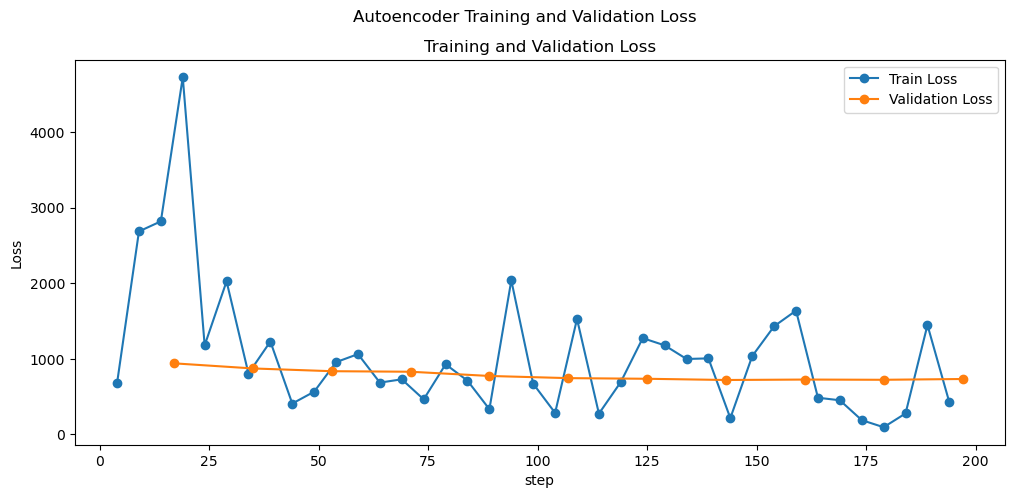

In [17]:
from utils.helper_functions import make_plots


history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")
make_plots(history, "Autoencoder Training and Validation Loss")

In [11]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}
best_model = model =NNRegressor(
        input_dim=len(cancer_dm.ds_train[0][0]),
        n_layers=study.best_trial.params["n_layers"],
        dropout=study.best_trial.params["dropout"],
        activation=activation_dict[study.best_trial.params["activation"]],
        optimizer=optimizer_dict[study.best_trial.params["optimizer"]],
        lr=study.best_trial.params["learning_rate"],
        weight_decay=study.best_trial.params["weight_decay"],
    )

In [12]:
joblib.dump(
    best_model,
    f"results/04/best_model_trial_noae_{study.best_trial.number}.pkl",
)

['results/04/best_model_trial_noae_17.pkl']

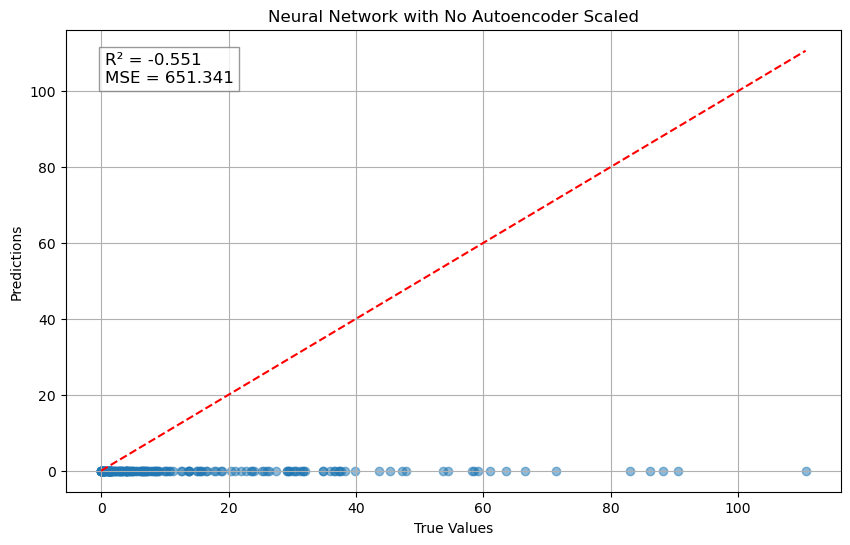

In [18]:
plot_regression_results(best_model, cancer_dm.test_dataloader(), title="Neural Network with No Autoencoder Scaled")